# Lab N: Hierarchical Bayesian Models
#### [Penn State Astroinformatics Summer School 2022](https://sites.psu.edu/astrostatistics/astroinfo-su22-program/)
#### [Joel Leja](http://www.personal.psu.edu/jql6565/)
#### (Examples based upon the franken-z photometric redshift code by [Dr. Josh Speagle](https://github.com/joshspeagle))


A common task in scientific analysis is to characterize a population of objects using data from individual objects which make up that population. For example, you may want to use observations of Earth-analogs to understand how many Earth-like planets exist in the solar system ([Foreman-Mackey et al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...795...64F/abstract)). Or perhaps you want to use far-IR observations of dust emission in molecular clouds to determine their distributions of temperature and emissivity ([Kelly et al. 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...752...55K/abstract)). The goal doesn't even have to be the characteristics of the population itself, it can instead be the rules governing that population. For example, perhaps your interests are cosmological, and you're interested in combining observations of Type 1a supernovae, correcting each for their local dust environment and host galaxy effects, to infer the values of cosmological parameters such as $\Omega_m$ and the redshift evolution of dark energy ([Shariff et al. 2016](https://ui.adsabs.harvard.edu/abs/2016ApJ...827....1S/abstract)).

A **Hierarchical Bayesian Model** is often an excellent choice for performing these tasks. It can take as inputs full Bayesian posteriors from individual objects. It is possible to directly address challenging components of the modeling, such as biases in the data, target selection function, or correlated measurements. Finally, one can take the population model and re-apply it to individual objects as an *informed prior*, thereby increasing your measurement precision for free! This last effect is known as **hierarchical shrinkage**.

We will discuss these one at a time.

#### Things we will learn (or review):
- Lecture part 1: Population models, priors, sampling
  - [Generating Noisy Measurements](#1.-Exploring-Our-Data)
  - [Building a Population Model](#2.-Building-a-Population-Model)
  - [Defining Priors for Hyper-Parameters](3.-Priors-for-Hyper-Parameters)
  - [Sampling our Posteriors](4.-Sampling-Our-Posterior)
- Lecture part 2: Hierarchical models
  - [Completing the Circle: Hierarchical Shrinkage](5.-Hierarchical-Shrinkage)
- Lecture part 3: Adding tools to describe noisy/missing/biased data
  - [(Bonus) Modeling Selection Effects](6.-Modeling-Selection-Effects-(Extra-Credit!))
  - [(Bonus) Modeling Observational Biases](7.-Modeling-Outliers-(Extra-Credit!))


#### Exercises (things you will be able to do!):
##### During Class: 
- Building a population model in a hierarchical framework
- Fitting this model to data
- Using the population model to improve individual inferences

#### And what's the point of the exercises?
- Understand how to layer Bayesian models on top of one another using Bayes theorem.
- Improve your fits to individual objects by performing hierarchical shrinkage.
- Use population models to model complex effects such as selection and data biases.

# 0. Setup

Run the blocks of code below. The first block will import some useful packages and standardize our plot geometry so that everyone's plots should look the same. The second block will define some boilerplate code for your sampling later.

In [ ]:
# imports
import sys
import pickle
import numpy as np
import scipy.stats as stats
import scipy
from scipy.special import erf
import matplotlib
from matplotlib import pyplot as plt

# plot in-line within the notebook
%matplotlib inline

# A block of code to specify plotting defaults
# run it to standardize your plot geometry!
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'axes.titlepad': '15.0'})
rcParams.update({'font.size': 20})

# Science should be repeatable
np.random.seed(7001826)

In [ ]:
# Some useful functions for building our models
# Run to compile them for later use.
# The code comes from the frankenz package, by Josh Speagle
# https://github.com/joshspeagle/frankenz

# Evaluate a Gaussian PDF averaged over bins of a finite width
def gaussian_bin(mu, std, bins):
    """
    Gaussian kernal with mean `mu` and standard deviation `std` evaluated
    over a set of bins with edges specified by `bins`.
    Returns the PDF integrated over the bins (i.e. an `N - 1`-length vector).
    """

    dif = bins - mu  # difference
    y = dif / (np.sqrt(2) * std)  # divide by relative width
    cdf = 0.5 * (1. + erf(y))  # CDF evaluated at bin edges
    pdf = cdf[1:] - cdf[:-1]  # amplitude integrated over the bins
    return pdf

# A class for sampling from a population, where the population model
# is a histograms with fixed bins of variable height
class population_sampler(object):
    """
    Sampler for drawing redshift population distributions given a set of
    individual redshift PDFs.

    """

    def __init__(self, pdfs):
        """
        Initialize the sampler.

        Parameters
        ----------
        pdfs : `~numpy.ndarray` of shape `(Nobs, Nbins,)`
            The individual redshift PDFs that make up the sample.

        """

        # Initialize values.
        self.pdfs = pdfs
        self.samples = []
        self.samples_lnp = []

    def reset(self):
        """Re-initialize the sampler."""

        self.samples = []
        self.samples_lnp = []

    @property
    def results(self):
        """Return samples."""

        return np.array(self.samples), np.array(self.samples_lnp)

    def run_mcmc(self, Niter, logprior_nz=None, pos_init=None,
                 thin=400, mh_steps=3, rstate=None, verbose=True,
                 prior_args=[], prior_kwargs={}):
        """
        Sample the distribution using MH-in-Gibbs MCMC.

        Parameters
        ----------
        Niter : int
            The number of samples to draw/iterations to run.

        logprior_nz : func, optional
            A function that returns the ln(prior) on `pos`.

        pos_init : `~numpy.ndarray` of shape `(Ndim,)`, optional
            The initial position from where we should start sampling.
            If not provided, the last position available from the previous
            set of samples will be used. If no samples have been drawn, the
            initial position will be the stacked PDFs.

        thin : int, optional
            The number of Gibbs samples (over random pairs) to draw
            before saving a sample. Default is `400`.

        mh_steps : int, optional
            The number of Metropolis-Hastings proposals within each Gibbs
            iteration. Default is `3`.

        rstate : `~numpy.random.RandomState`
            `~numpy.random.RandomState` instance.

        verbose : bool, optional
            Whether or not to output a simple summary of the current run that
            updates with each iteration. Default is `True`.

        prior_args : args, optional
            Optional arguments for `logprior_nz`.

        prior_kwargs : args, optional
            Optional keyword arguments for `logprior_nz`.

        """

        # Initialize values.
        Nobs, Ndim = self.pdfs.shape
        if rstate is None:
            rstate = np.random

        # Initialize prior.
        if logprior_nz is None:
            def logprior_nz(pos, *prior_args, **prior_kwargs):
                return 0.

        # Initialize starting position.
        if pos_init is None:
            try:
                # Try to start from out last position.
                pos = self.samples[-1]
            except:
                # Otherwise, just stack the individual PDFs.
                pos = self.pdfs.sum(axis=0) / self.pdfs.sum()
                pass
        else:
            # Use provided position.
            pos = pos_init

        # Sample.
        for i, (x, lnp) in enumerate(self.sample(Niter,
                                                 logprior_nz=logprior_nz,
                                                 pos_init=pos_init, thin=thin,
                                                 mh_steps=mh_steps,
                                                 rstate=rstate,
                                                 prior_args=prior_args,
                                                 prior_kwargs=prior_kwargs)):

            self.samples.append(np.array(x))
            self.samples_lnp.append(lnp)
            if verbose:
                sys.stderr.write('\r Sample {:d}/{:d} [lnpost = {:6.3f}]      '
                                 .format(i+1, Niter, lnp))
                sys.stderr.flush()

    def sample(self, Niter, logprior_nz=None, pos_init=None, thin=400,
               mh_steps=3, rstate=None, prior_args=[], prior_kwargs={}):
        """
        Internal generator used for MH-in-Gibbs MCMC sampling.

        Parameters
        ----------
        Niter : int
            The number of samples to draw/iterations to run.

        logprior_nz : func, optional
            A function that returns the ln(prior) on `pos`.

        pos_init : `~numpy.ndarray` of shape `(Ndim,)`, optional
            The initial position from where we should start sampling.
            If not provided, the last position available from the previous
            set of samples will be used. If no samples have been drawn, the
            initial position will be the stacked PDFs.

        thin : int, optional
            The number of Gibbs samples (over random pairs) to draw
            before saving a sample. Default is `400`.

        mh_steps : int, optional
            The number of Metropolis-Hastings proposals within each Gibbs
            iteration. Default is `3`.

        rstate : `~numpy.random.RandomState`
            `~numpy.random.RandomState` instance.

        verbose : bool, optional
            Whether or not to output a simple summary of the current run that
            updates with each iteration. Default is `True`.

        prior_args : args, optional
            Optional arguments for `logprior_nz`.

        prior_kwargs : args, optional
            Optional keyword arguments for `logprior_nz`.

        """

        # Initialize values.
        Nobs, Ndim = self.pdfs.shape
        if rstate is None:
            rstate = np.random

        # Initialize prior.
        if logprior_nz is None:
            def logprior_nz(pos, *prior_args, **prior_kwargs):
                return 0.

        # Initialize starting position.
        if pos_init is None:
            pos = self.pdfs.sum(axis=0) / self.pdfs.sum()
        else:
            pos = pos_init
        lnlike, overlap = loglike_nz(pos, self.pdfs, return_overlap=True)
        lnprior = logprior_nz(pos, *prior_args, **prior_kwargs)
        lnpost = lnlike + lnprior

        # Sample.
        for i in range(Niter):
            # Generate random pairs.
            pairs = [rstate.choice(Ndim, size=2, replace=False)
                     for i in range(thin)]
            # Gibbs step.
            for pair in pairs:
                # Generate (i, j) basis vector.
                t = np.zeros_like(pos)
                t[pair] = (1, -1)
                # Compute absolute range.
                scale = 1e-4 * np.min(np.append(pos[pair], 1. - pos[pair]))
                # Compute numerical gradient.
                lnp1 = loglike_nz(pos, self.pdfs, overlap=overlap,
                                  pair=pair, pair_step=scale/2.)
                lnp1 += logprior_nz(pos + t*scale/2.,
                                    *prior_args, **prior_kwargs)
                lnp2 = loglike_nz(pos, self.pdfs, overlap=overlap,
                                  pair=pair, pair_step=-scale/2.)
                lnp2 += logprior_nz(pos - t*scale/2.,
                                    *prior_args, **prior_kwargs)
                grad = (lnp1 - lnp2) / scale
                # Rescale so that we're looking at changes in log(post) of ~ 1.
                if grad != 0.:
                    gscale = min(abs(1. / grad), abs(scale * 1e4))
                else:
                    gscale = abs(scale)

                # Metropolis-Hastings step.
                for k in range(mh_steps):
                    # Generate proposal.
                    z = rstate.randn() * gscale
                    # Generate new proposal.
                    pos_new = pos + (t * z)
                    lnlike_new, overlap_new = loglike_nz(pos_new, self.pdfs,
                                                         overlap=overlap,
                                                         return_overlap=True,
                                                         pair=pair,
                                                         pair_step=z)
                    lnprior_new = logprior_nz(pos_new,
                                              *prior_args, **prior_kwargs)
                    lnpost_new = lnlike_new + lnprior_new
                    # Metropolis update.
                    if -rstate.exponential() < lnpost_new - lnpost:
                        pos, lnpost, overlap = pos_new, lnpost_new, overlap_new

            # Return current position.
            yield pos, lnpost
            

# 1. Exploring Our Data

**Note**: The following examples are based upon the franken-z photometric redshift code by [Dr. Josh Speagle](https://github.com/joshspeagle), a postdoctoral fellow at the University of Toronto.

We will begin by loading a set of (pre-generated) *photometric redshifts* from a galaxy population. These are noiseless to begin with. 

In [ ]:
redshifts = pickle.load(open('data/mock_sdss_cww_bpz.pkl', 'rb'))  # load data
Nobs = len(redshifts)

print('Number of observed redshifts:', Nobs)

Number of observed redshifts: 20000


Now we will simulate observations of these systems by adding a modest amount of Gaussian noise to them. We will assume the mean of each observation is shifted from the true value following this noise distribution, then create an observed probability distribution function (PDF) for each object. While no self-respecting astronomer would do this in practice, we will allow negative redshifts in our data in order to avoid edge effects.

In [ ]:
# generate a uniform redshift grid
dzgrid = 0.01
zgrid = np.arange(-1., 7.+1e-5, dzgrid)

# Generate noise values (sigma = 0.05 - 0.2) and simulate new observational means
sigma = np.random.uniform(0.05, 0.2, size=Nobs)  # width
mu = np.random.normal(redshifts, sigma)  # noisy observation

# simulate Nobs observations of varying noise levels (sigma = 0.05 - 0.2)
zpdf = np.array([stats.norm.pdf(zgrid, mu[i], sigma[i]) 
                 for i in range(Nobs)])  # redshift pdfs
zpdf /= np.trapz(zpdf, zgrid)[:,None]  # normalizing

print('Now we have {0} noisy redshifts on a redshift grid of size {1}.'.format(zpdf.shape[0],zpdf.shape[1]))

Now we have 20000 noisy redshifts on a redshift grid of size 801.


Done! Let's take a quick look at our data to make sure everything looks good. We'll plot 6 random PDFs representing our observations.

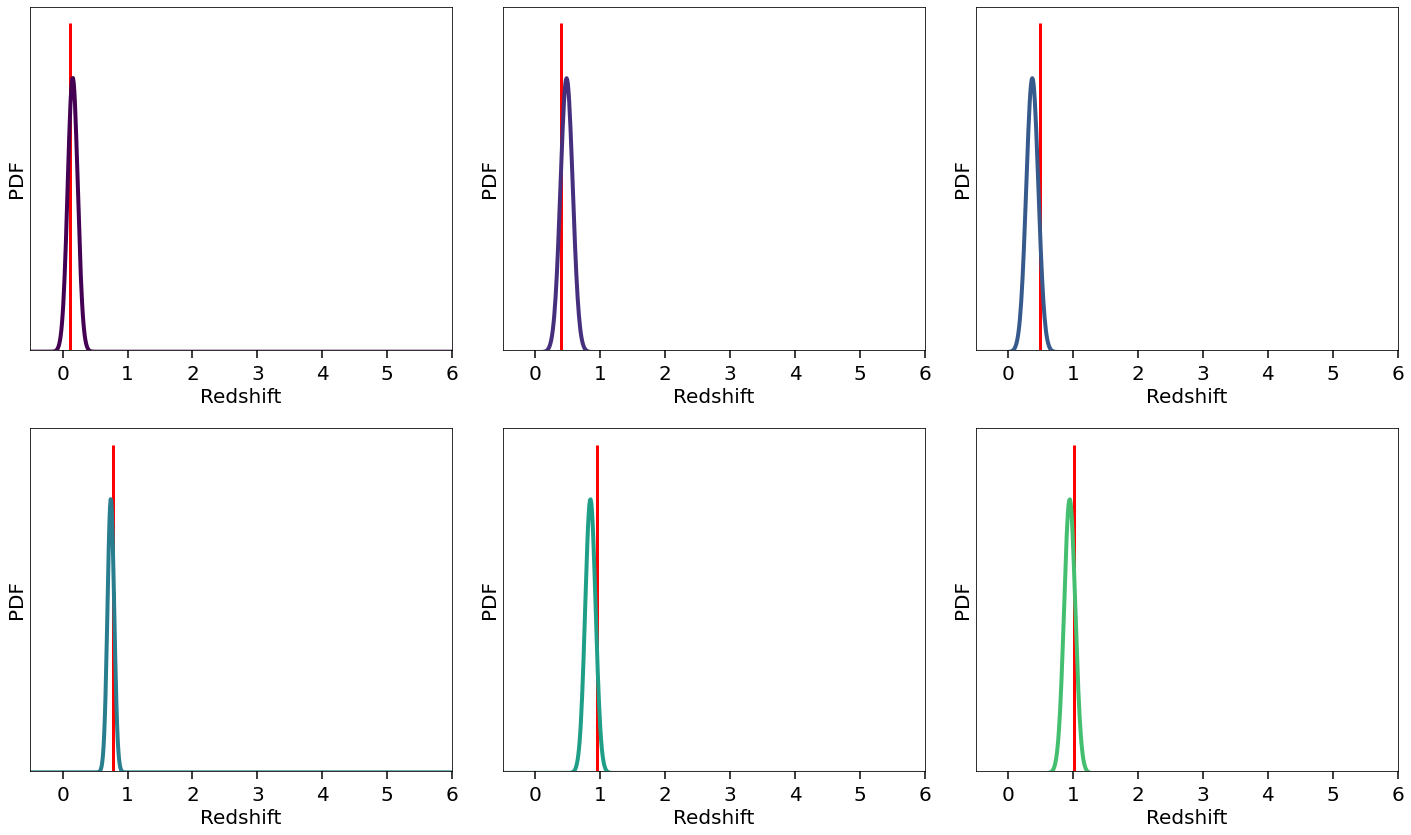

In [ ]:
# Generate a redshift grid
dzbin = 0.1
zbins = np.arange(-1, 7.+1e-5, dzbin)  # redshift bins
zbins_mid = 0.5 * (zbins[1:] + zbins[:-1])  # bin midpoints
Nbins = len(zbins) - 1

# plot some PDFs
plt.figure(figsize=(20, 12))
Nfigs = (2, 3)
Nplot = np.prod(Nfigs)
colors = plt.get_cmap('viridis')(np.linspace(0., 0.7, Nplot))
idxs = np.random.choice(Nobs, size=Nplot)
idxs = idxs[np.argsort(redshifts[idxs])]
for i, (j, c) in enumerate(zip(idxs, colors)):
    plt.subplot(Nfigs[0], Nfigs[1], i + 1)
    plt.plot(zgrid, zpdf[j], color=c, lw=4)
    plt.vlines(redshifts[j], 0., max(zpdf[j] * 1.2), color='red', 
               lw=3)
    plt.xlim([-0.5, 6])
    plt.ylim([0.03, None])
    plt.xlabel('Redshift')
    plt.yticks([])
    plt.ylabel('PDF')
    plt.tight_layout()

Our data is in place, and indeed, they look noisy! Now let's turn our attention to the population as a whole. What does the redshift distribution look like? How does that compare to our observations? Well for now we'll do the very simplest thing, and stack the PDFs of all of the individual observations. *How bad can this be?*

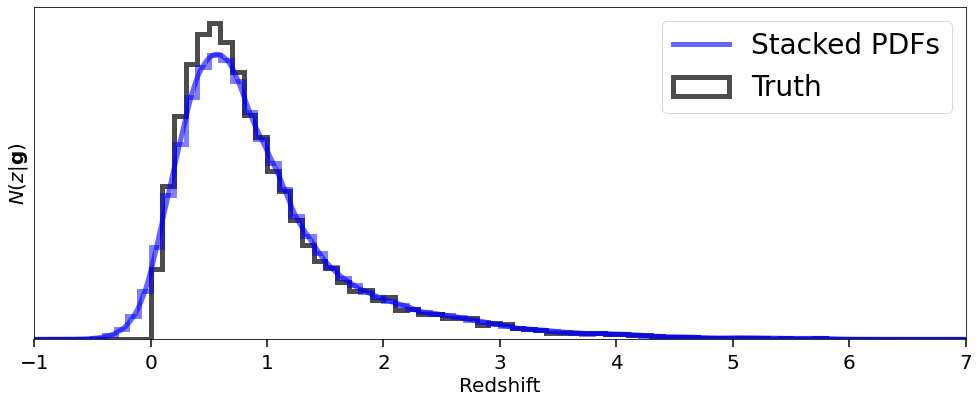

In [ ]:
# generate redshift bins
dzbin = 0.1
zbins = np.arange(-1, 7.+1e-5, dzbin)  # redshift bins
zbins_mid = 0.5 * (zbins[1:] + zbins[:-1])  # bin midpoints
Nbins = len(zbins) - 1

# bin up our observed PDFs
# We use a special function to do this, which evaluates a Gaussian
# PDF over a bin size
# Generate the Gaussian PDF, in bins
zpdf_bins = np.array([gaussian_bin(mu[i], sigma[i], zbins) 
                      for i in range(Nobs)])  # redshift pdfs
zpdf_bins /= zpdf_bins.sum(axis=1)[:,None] * dzbin  # normalizing
# We'll also define a normalized version -- this will be useful later!
zpdf_norm = zpdf_bins / zpdf_bins.sum(axis=1)[:, None]


# Plot both quantities
plt.figure(figsize=(14, 6))
plt.plot(zgrid, zpdf.sum(axis=0) / Nobs, lw=5, color='blue',
         alpha=0.6, label='Stacked PDFs')
plt.hist(redshifts, bins=zbins, histtype='step', lw=5,
         color='black', alpha=0.7, density=True,label='Truth')
plt.hist(zbins_mid, bins=zbins, weights=zpdf_bins.sum(axis=0) / Nobs,
         histtype='step', lw=5,
         color='blue', alpha=0.5, density=True)
plt.xlabel('Redshift')
plt.xlim([zgrid[0], zgrid[-1]])
plt.yticks([])
plt.ylabel('$N(z|\mathbf{g})$')
plt.ylim([0., None])
plt.legend(fontsize=28, loc='best')
plt.tight_layout()

Why don't these two agree? Well, we've added noise! This means that the noisy PDFs are no longer an accurate reconstruction of the true population of galaxies. This should make sense intuitively -- noise *broadens* the overall distribution, so estimating the population redshift distribution $P(z|\mathbf{g})$ (i.e., the probability of a redshift observation given a population of galaxies $\mathbf{g}$) requires **deconvolving** the noisy observations.

To make further progress we'll have to build a model for our observations. 

# 2. Building a Population Model
Our model for the population should **maximize the posterior probability** according to Bayes' theorem. How will we model the population?

For now we will take a simple and flexible approach by modeling the population as a series of redshift **bins** (i.e. a histogram), which can be modeled using a **top-hat kernel** consisting of a product of **Heavyside functions**.

Below we define the likelihood for our population model. This is used in conjunction with the above **population sampler** object in order to fit our population model to the data. <span style="color:red"> You will fill in our likelihood -- recall from the lecture how to write down a likelihood for a population model defined by histograms! </span>

In [ ]:
# We'll have to remove some pieces of this so students can fill in.
def loglike_nz(nz, pdfs, overlap=None, return_overlap=False,
               pair=None, pair_step=None):
    """
    Compute the log-likelihood for the provided population redshift
    distribution `nz` given a collection of PDFs `pdfs`. Assumes that the
    distributions both are properly normalized and sum to 1.

    Parameters
    ----------
    nz : `~numpy.ndarray` of shape `(Nbins,)`
        The population redshift distribution.

    pdfs : `~numpy.ndarray` of shape `(Nobs, Nbins,)`
        The individual redshift PDFs that make up the sample.

    overlap : `~numpy.ndarray` of shape `(Nobs,)`
        The overlap integrals (sums) between `pdfs` and `nz`. If not provided,
        these will be computed.

    return_overlap : bool, optional
        Whether to return the overlap integrals. Default is `False`.

    pair : 2-tuple, optional
        A pair of indices `(i, j)` corresponding to a pair of bins that will
        be perturbed by `pair_step`.

    pair_step : float, optional
        The amount by which to perturb the provided pair `(i, j)` in the
        `(+, -)` direction, respectively.

    Returns
    -------
    loglike : float
        The computed log-likelihood.

    """

    # Check for negative values.
    perturb = 0.
    if np.any(~np.isfinite(nz) | (nz < 0.)):
        lnlike, overlap = -np.inf, np.zeros(len(pdfs))
    else:
        # Compute overlap.
        if overlap is None:
            overlap = np.dot(pdfs, nz)
        # Compute perturbation from pair.
        if pair is not None:
            i, j = pair
            if pair_step is not None:
                perturb = pair_step * (pdfs[:, i] - pdfs[:, j])
        # Compute log-likelihood.
        lnlike = np.sum(np.log(overlap + perturb))

    if return_overlap:
        return lnlike, overlap + perturb
    else:
        return lnlike

# 3. Priors for Hyper Parameters
We will take $P(\boldsymbol{\rho})$ to be a **Dirichlet** distribution. Generically, a Dirichlet distribution is a set of numbers between 0 and 1 which all sum up to 1. The Dirichlet distribution is defined by a set 

$$ \boldsymbol{\rho} \sim {\rm Dir}\left(\mathbf{m} + \boldsymbol{\alpha}\right) $$

where $\boldsymbol{\alpha} = \mathbf{1}$ are a set of concentration parameters (with 1 being uniform) and $\mathbf{m}$ being a set of counts we've previously observed. The concentration parameters determine how evenly distributed the values are: high concentration parameters mean that most of the weight will be in a handful of bins, whereas low concentration numbers mean that we expect them to be evenly distributed. We will come back to this particular choice of prior later when we deal with hierarchical models.

Below we'll define our prior:

In [ ]:
# grab representative set of previous redshifts
Nref = 1000
redshifts_ref = redshifts[-Nref:]
alpha = np.ones(Nbins) # the Dirichlet parameter
counts_ref, _ = np.histogram(redshifts_ref, bins=zbins)

# define our prior
def logprior(x, alpha=None, counts_ref=None):
    
    if alpha is None:
        alpha = np.ones_like(x)
    if counts_ref is None:
        counts_ref = np.zeros_like(x)
    if np.any(x < 0.):
        return -np.inf

    return scipy.stats.dirichlet.logpdf(x, alpha + counts_ref)

# 4. Sampling Our Posterior

We now turn to the challenge of generating samples from our distribution. While there are several ways to theoretically do this, we will focus on **Markov Chain Monte Carlo** methods. Due to the constraint that $\boldsymbol{\rho}$ must sum to 1, we are sampling from this distribution on the $(N_h - 1)$-dimensional **simplex** since the amplitude of the final bin is always determined by the remaining bins. This creates an additional challenge, since changing one bin will always lead to changes in the other bins. 

While we could attempt to sample this distribution directly using **Metropolis-Hastings (MH) updates**, given the number of parameters involved in specifying our population distribution $\boldsymbol{\rho}$ it is likely better to use **Gibbs sampling** to iterate over conditionals. To satisfy the summation constraint, we opt to use an approach where we update bins $(i, j)$ pairwise so that $i^\prime + j^\prime = (i + \Delta i) + (j + \Delta j) = i + j \Rightarrow \Delta j = -\Delta i = z$, where $z$ is now our step-size over the bins. We generate proposals for each random pair of bins using MH proposals where the scale is determined adaptively by estimating the gradient for $\partial/\partial z$ at each iteration to aim for optimal acceptance fractions.

In [ ]:
# initialize sampler
sampler = population_sampler(zpdf_norm)

# run MH-in-Gibbs MCMC
Nburn = 250
Nsamples = 500
sampler.run_mcmc(Nsamples + Nburn, logprior_nz=logprior, prior_args=[alpha, counts_ref])

 Sample 750/750 [lnpost = -64358.619]      

Excellent! Now let's compare the results of our population model to our earlier approach of simply stacking the posteriors.

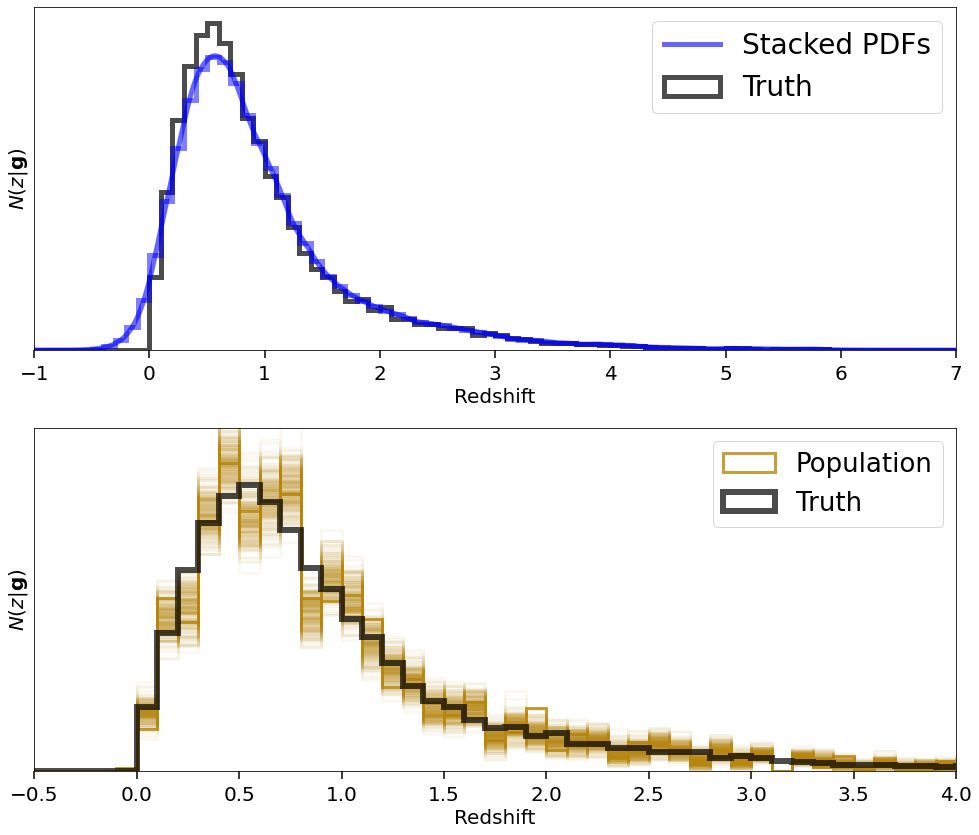

In [ ]:
# grab samples
pdf_samples, pdf_lnps = sampler.results
pdf_samples = pdf_samples[-500:] * Nobs  # truncate and rescale

# Plot the summed PDFs
plt.figure(figsize=(14, 12))
plt.subplot(2, 1, 1)
plt.plot(zgrid, zpdf.sum(axis=0) / Nobs, lw=5, color='blue',
         alpha=0.6, label='Stacked PDFs')
plt.hist(redshifts, bins=zbins, histtype='step', lw=5,
         color='black', alpha=0.7, density=True,label='Truth')
plt.hist(zbins_mid, bins=zbins, weights=zpdf_bins.sum(axis=0) / Nobs,
         histtype='step', lw=5,
         color='blue', alpha=0.5, density=True)
plt.xlabel('Redshift')
plt.xlim([zgrid[0], zgrid[-1]])
plt.yticks([])
plt.ylabel('$N(z|\mathbf{g})$')
plt.ylim([0., None])
plt.legend(fontsize=28, loc='best')
plt.tight_layout()

# now plot our population model results!
def zplot_bin(samples, label='type', color='blue', downsample=2):
    """Plot our binned draws."""
    [plt.hist(zbins_mid + 1e-5, zbins, 
              weights=samples[i], lw=3,
              histtype='step', color=color, 
              alpha=0.8 if i == 0 else 0.05, # for the legend
              label=label if i == 0 else "") # for the legend
     for i in np.arange(Nsamples)[::downsample]]
    h = plt.hist(redshifts, zbins, label='Truth',
                 histtype='step', lw=6, color='black', alpha=0.7)
    plt.xlabel('Redshift')
    plt.xlim([-0.5, 4])
    plt.yticks([])
    plt.ylim([0, max(h[0]) * 1.2])
    plt.ylabel('$N(z|\mathbf{g})$')
    plt.legend(fontsize=26, loc='best')
    plt.tight_layout()

# plotting
plt.subplot(2, 1, 2)
zplot_bin(pdf_samples, label='Population', color='darkgoldenrod')

# 5. Hierarchical Shrinkage
While the above results have looked at the marginalized distribution of $\boldsymbol{\rho}$, we can use our results to generate the marginalized distributions for each of our objects $P(z|g)$. Because these apply the prior learned from the population, the individual PDFs are often better-constrained as a result. This effect is known as **hierarchical shrinkage**.

This is important -- we're applying our population posterior as a prior for individual objects. Now we understand the results better for individual systems!

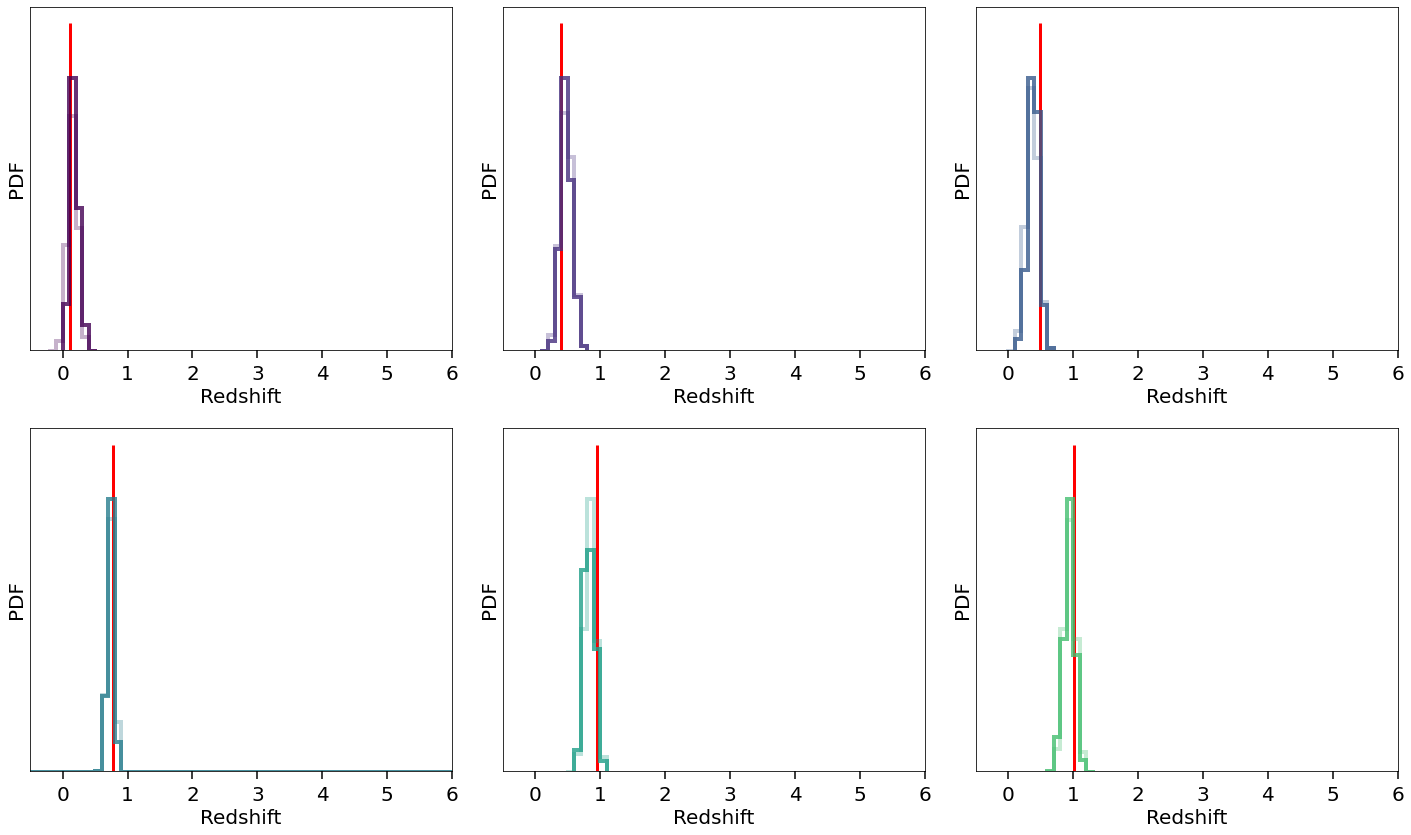

In [ ]:
# plot new PDFs
plt.figure(figsize=(20, 12))
for i, (j, c) in enumerate(zip(idxs, colors)):
    plt.subplot(Nfigs[0], Nfigs[1], i + 1)
    n1, _, _ = plt.hist(zbins_mid, zbins, weights=zpdf_bins[j], 
                        color=c, lw=4, alpha=0.3, histtype='step',
                        density=True)
    zpdf_bins_t = np.sum([np.random.multinomial(10, (zpdf_bins[j] * p / 
                                                np.dot(zpdf_bins[j], p)))
                          for p in pdf_samples], axis=0)
    n2, _, _ = plt.hist(zbins_mid, zbins, weights=zpdf_bins_t, 
                        color=c, lw=4, alpha=0.8, histtype='step',
                        density=True)
    plt.vlines(redshifts[j], 0., np.max([n1, n2]) * 1.2, color='red', 
               lw=3)
    plt.xlim([-0.5, 6])
    plt.ylim([0.03, None])
    plt.xlabel('Redshift')
    plt.yticks([])
    plt.ylabel('PDF')
    plt.tight_layout()

The plots above show the redshift PDFs for individual objects. The dark lines represent the posteriors after shrinkage, while the light lines represent the original posteriors.

Recall that we allowed negative redshifts inferences at the start. However, our population model is 'correct' and does not allow negative redshifts. Look at the first object: we've substantially shrunk the allowed parameter space by applying our hierarchical model!

In general, hierarchical shrinkage can either be applied post-fit as we do here, or the fit to the individual objects plus the population sampling can proceed simultaneously.

# 6. Modeling Selection Effects (Extra Credit!)
Let's assume that our data has been generated with some non-trivial **selection function**, i.e. we are not observing the full population but instead some subset of it (almost always the case in astronomy!). How do we model this? A good example is in [Foreman-Mackey et al. 2014](https://ui.adsabs.harvard.edu/abs/2014ApJ...795...64F/abstract), Section 5.

Here we will assume a detection efficiency of $Q_t = \frac{n_{obs}}{n_{population}} = \frac{1}{1+z}$, i.e. objects at higher redshift are harder to find (not unreasonable!). Implement this into our code above and see how our inferred population density changes!

In [ ]:
# Your work here

# 7. Modeling Outliers (Extra Credit!)
Let's assume that some (small) fraction of our data $f$ are _outliers_, i.e. the inferred redshifts are not consistent with our population model. Below we will step through how to model these by altering the likelihood.

- Examine the likelihood for this so-called _mixture model_ in Section 3 of the [classic paper](https://ui.adsabs.harvard.edu/abs/2010arXiv1008.4686H/abstract) _Data analysis recipes: Fitting a model to data_ by David Hogg, Jo Bovy, and Dustin Lang.
- Choose some fraction $f$ of your data to be outliers. To these objects, instead add $20\sigma$ uncertainties.
- Rewrite the likelihood function to include the outlier fraction $f$.
- See if you can recover the outlier fraction by sampling the data!

In [ ]:
# Your work here